In [121]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# RUN BLR

In [1]:
! rm -r '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'
! mkdir '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'

In [3]:
import os
os.chdir('/Users/ltran/Documents/TrueData29/CPC_ML_tutorial/')

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import random

from scipy.stats import fisher_exact
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d
from sklearn.model_selection import train_test_split
# Set data directory
data_dir = '/Users/ltran/Documents/Data/'

# Set working directory
root_dir = '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/'
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

## Load DF_ALL

In [32]:
df_tca = pd.read_csv(os.path.join(data_dir, 'Outputs/df_tca_age.csv'))

In [33]:
df_tsa = pd.read_csv(os.path.join(data_dir, 'Outputs/df_tsa_age.csv'))

In [34]:
df_td = pd.read_csv(os.path.join(data_dir, 'Outputs/df_td_age.csv'))

### Define ROI

In [35]:
df_tca = df_tca[df_tca.ASD != 'TCA_Autism']

In [65]:
all_cols = ['EstimatedTotalIntraCranialVol', 'Left-Lateral-Ventricle']
idp_ids = all_cols

In [37]:
all_cols = [col for col in df_tca.columns if '_thickness' in col]


In [41]:
all_cols.remove('rh_MeanThickness_thickness')
all_cols.remove('lh_MeanThickness_thickness')

In [42]:
len(all_cols)

68

## Plot data

# Run BLR

In [48]:
pred_bool = input("Prediction on TD + ASD : 1 \nPrediction on ASD only : 2\n")

Prediction on TD + ASD : 1 
Prediction on ASD only : 2
2


In [74]:
# Metric DataFrame
metric_analysis = pd.DataFrame(columns = ['ROIs', 'EV mean', 'EV max', 'MSLL mean', 'MSLL min', 'Covs', 'Fixed effect', 'xmin', 'xmax', 'Outlier Thresh'])



In [75]:
# Choosing covariates
cols_cov = ['age_at_first_scan','sex']

fixed_effect = 'NA'

# Type of Warping 
warp =  'WarpSinArcsinh'


# B-Spline limits
xmin = round(df_all['age_at_first_scan'].min() - 5) # ~ age min - 5 
xmax = round(df_all['age_at_first_scan'].max() + 5) # ~ age max + 5

force_refit = True 

# Threshold for outliers
outlier_thresh = 5

In [76]:
# DataFrame with only TD
df_td = df_all.loc[df_all.ASD == 'No']
df_asd = df_all.loc[df_all.ASD == 'Yes']
df_relatives = df_all.loc[df_all.ASD == 'Relative']

strat = ['age_at_first_scan', 'sex', 'site']
if (pred_bool == '1'):
    
    

    #Split train & test, stratified by site
    df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
                                                        test_size=0.33, 
                                                        random_state=42,
                                                       stratify = df_td[ 'site'])

    df_trx, df_tex2, df_try, df_tey2 = train_test_split(df_sx, df_sy, 
                                                       test_size = 0.5, random_state=42, 
                                                      stratify = df_sx[ 'site'])

    df_te1 = df_tex1.join(df_tey1)
#     df_te2 = df_tex2.join(df_tey2)
#     df_te2 = df_te2.join(df_all, how = 'left', lsuffix = '', rsuffix='r')
    df_te2 = df_tex2.join(df_tey2).join(df_all[['ASD', 'participant_id']])
    df_te3 = pd.concat([df_te2, df_asd, df_relatives])
    df_tr = df_trx.join(df_try)
#     df_te3 = pd.concat([df_te2, df_asd, df_relatives])
elif (pred_bool == '2'):
    
    df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
                                                    test_size=0.5, 
                                                    random_state=42,
                                                   stratify = df_td['site'])
    df_tr = df_sx.join(df_sy)
    df_te1 = df_tex1.join(df_tey1)
    df_te3 = df_asd.copy()

In [78]:
site_ids = set(df_all['site'])
site_ids_tr = set(df_tr['site'])
site_ids_te = set(df_te1['site'])


for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')

    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)

    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te1[idp].to_numpy()

    # remove gross outliers and implausible values
    yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
    nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
    y_tr = y_tr[nz_tr]
    y_te = y_te[nz_te]

    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)

    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov].loc[nz_tr], 
                                site_ids = df_tr['site'].loc[nz_tr],
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te1[cols_cov].loc[nz_te], 
                                site_ids = df_te1['site'].loc[nz_te], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'

        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', 
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)

    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  

        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp

        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]

        # evaluation metrics
        metrics = evaluate(y_te, med_te)

        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     

    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtfddfosis, semean, sesd] = calibration_descriptives(Z)

    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik

    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]

display(blr_metrics)

blr_metrics.to_csv(os.path.join(out_dir,'blr_metrics.csv'))
new_row = {'ROIs' : len(idp_ids) , 'EV mean': blr_metrics['EV'].mean(), 'EV max' : blr_metrics['EV'].max() , 'MSLL mean': blr_metrics['MSLL'].mean(), 'MSLL min' : blr_metrics['MSLL'].min(), 'Covs' : cols_cov, 'Fixed effect' : fixed_effect , 'xmin' : xmin, 'xmax' : xmax, 'Outlier Thresh' : outlier_thresh}
metric_analysis = metric_analysis.append(new_row, ignore_index=True)

Running IDP 0 EstimatedTotalIntraCranialVol :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/EstimatedTotalIntraCranialVol/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 1 Left-Lateral-Ventricle :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/Left-Lateral-Ventricle/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...


/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.14299e-22): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.56769e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.40787e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.50731e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/mo

,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
0,EstimatedTotalIntraCranialVol,1584.351627,0.117673,-149.271982,3187.751949,-0.221507,-0.109868
1,Left-Lateral-Ventricle,1148.112651,0.194000,-0.109559,2315.273997,0.574108,0.925140


/var/folders/p5/qymxnxk12156bhtw2jlf3sb40000gr/T/ipykernel_7315/2667643027.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_analysis = metric_analysis.append(new_row, ignore_index=True)


In [79]:
blr_metrics.EV.mean()

0.15583619245434482

In [80]:
blr_metrics.describe()

,NLL,EV,MSLL,BIC,Skew,Kurtosis
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,1366.232139,0.155836,-74.690771,2751.512973,0.176300,0.407636
std,308.467538,0.053971,105.473761,616.935077,0.562585,0.731862
min,1148.112651,0.117673,-149.271982,2315.273997,-0.221507,-0.109868
25%,1257.172395,0.136755,-111.981376,2533.393485,-0.022604,0.148884
50%,1366.232139,0.155836,-74.690771,2751.512973,0.176300,0.407636
75%,1475.291883,0.174918,-37.400165,2969.632461,0.375204,0.666388
max,1584.351627,0.194000,-0.109559,3187.751949,0.574108,0.925140


In [81]:
#blr_metrics.loc[~(blr_metrics.eid == 'rh_caudalmiddlefrontal_thickness')].min()

In [83]:
# Metrics for each boostrap iteration
metric_analysis

,ROIs,EV mean,EV max,MSLL mean,MSLL min,Covs,Fixed effect,xmin,xmax,Outlier Thresh
0,2,0.155836,0.194,-74.690771,-149.271982,"[age_at_first_scan, sex]",NA,-3,83,5


## Predict Z-Scores

In [84]:

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # extract and save the response variables for the test set
    y_te = df_te3[idp].to_numpy()

    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_te, y_te)

    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te3[cols_cov], 
                                site_ids = df_te3['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)

    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')

        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg='blr', 
                                    respfile=resp_file_te, 
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')

        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov], 
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')          
        np.savetxt(cov_file_ad, X_ad)

        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt') 
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)

        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt') 
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)

        # save the site ids for the test data 
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)

        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg = 'blr', 
                                    respfile = resp_file_te, 
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 EstimatedTotalIntraCranialVol :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 Left-Lateral-Ventricle :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...


# Export train and test sets

In [85]:
df_tr.to_csv(os.path.join(data_dir, 'Outputs/df_tr.csv'), index = False)
df_te1.to_csv(os.path.join(data_dir, 'Outputs/df_te1.csv'), index = False)
df_te3.to_csv(os.path.join(data_dir, 'Outputs/df_te3.csv'), index = False)

## Export EV

In [86]:
blr_metrics.max()

eid         Left-Lateral-Ventricle
NLL                    1584.351627
EV                           0.194
MSLL                     -0.109559
BIC                    3187.751949
Skew                      0.574108
Kurtosis                   0.92514
dtype: object

In [87]:
blr_metrics.to_csv(os.path.join(data_dir, 'Outputs/blr_metrics.csv'), index = False)

## Plot trajectories

In [98]:
df_all['EstimatedTotalIntraCranialVol'].describe()

count    8.260000e+02
mean     1.422619e+06
std      1.682703e+05
min      7.780953e+05
25%      1.308923e+06
50%      1.421683e+06
75%      1.530683e+06
max      1.971102e+06
Name: EstimatedTotalIntraCranialVol, dtype: float64

In [109]:
df_all.columns

Index(['Measure:volume', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent',
       'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus',
       'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC',
       'Left-vessel', 'Left-choroid-plexus', 'Right-Lateral-Ventricle',
       'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC',
       'Right-vessel', 'Right-choroid-plexus', '5th-Ventricle',
       'WM-hypointensities', 'Left-WM-hypointensities',
       'Right-WM-hypointensities', 'non-WM-hypointensities',
       'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities',
       'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior',

In [88]:
sex = 1

configuring dummy data ...
Running IDP 0 EstimatedTotalIntraCranialVol :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([157450.7274167]), 'Rho': array([0.54489184]), 'pRho': array([7.69333272e-50]), 'SMSE': array([0.85699898]), 'EXPV': array([0.23738387])}


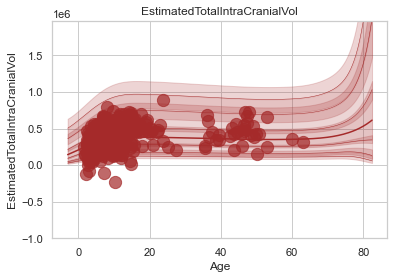

Running IDP 1 Left-Lateral-Ventricle :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([3568.877058]), 'Rho': array([0.25180816]), 'pRho': array([4.08286751e-10]), 'SMSE': array([0.99548785]), 'EXPV': array([0.03436098])}


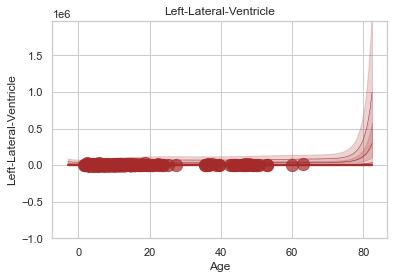

In [106]:
if (sex == 1): 
    clr = 'brown';
else:
    clr = 'red'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), len(cols_cov)))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, 
                               site_ids=None, 
                               all_sites=site_ids_tr
                              )

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))

    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set

            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue

            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset 

            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]

            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue

            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        
        plt.scatter(X_te[idx,1], y_te_rescaled, s=150, color=clr, alpha = 0.7)
        
    # plot the median of the dummy data
    plt.plot(xx, med, clr)

    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.2,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

    plt.ylim(-1e+06, 1.971102e+06)
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
#      plt.xlim((5,31))
    plt.savefig(os.path.join(idp_dir, 'centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(out_dir)